In [53]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision

import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import numpy as np

In [3]:
# 超参数
EPOCH = 50
BATCH_SIZE = 64
LR = 0.005
DOWNLOAD_MNIST = False  # 下过数据的话, 就可以设置成 False
N_TEST_IMG = 5          # 到时候显示 5张图片看效果, 如上图一

In [5]:
# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='./MNIST/data1/MNIST/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)

train_loader = Data.DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True)

torch.Size([60000, 28, 28])
torch.Size([60000])


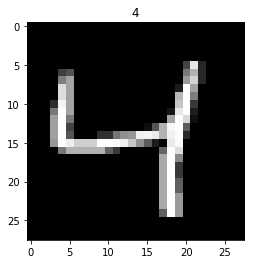

In [16]:
print(train_data.train_data.size())
print(train_data.train_labels.size())

plt.imshow(train_data.train_data[2].numpy(),cmap='gray')           #'gray' 显示灰度照片
plt.title(train_data.train_labels[2].numpy())
plt.show()

In [38]:
#自编码，中间压缩成了3维
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder,self).__init__()  
        
        #压缩
        self.encoder = nn.Sequential(
            nn.Linear(28*28,128),
            nn.Tanh(),
            nn.Linear(128,64),
            nn.Tanh(),
            nn.Linear(64,12),
            nn.Tanh(),
            nn.Linear(12,3)               # 压缩成3个特征, 进行 3D 图像可视化
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3,12),
            nn.Tanh(),
            nn.Linear(12,64),
            nn.Tanh(),
            nn.Linear(64,128),
            nn.Tanh(),
            nn.Linear(128,28*28),
            nn.Sigmoid(),                 # 激励函数让输出值在 (0, 1), 和0~255成等比例
        )
    
    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded,decoded

Epoch:  0 | train loss 0.2325 


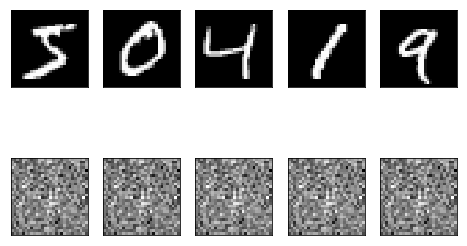

Epoch:  1 | train loss 0.0255 


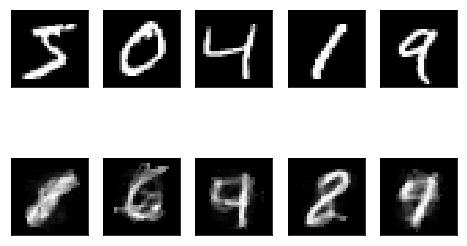

Epoch:  2 | train loss 0.0187 


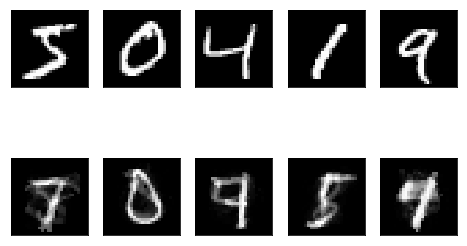

Epoch:  3 | train loss 0.0152 


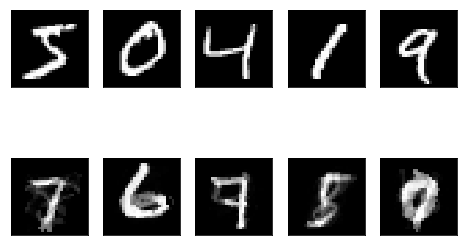

Epoch:  4 | train loss 0.0136 


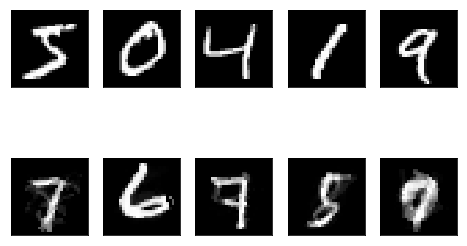

Epoch:  5 | train loss 0.0130 


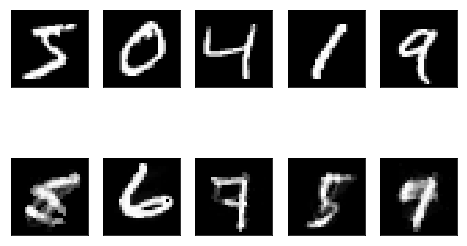

Epoch:  6 | train loss 0.0126 


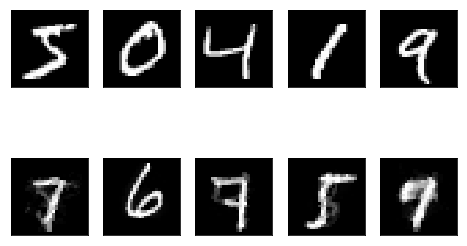

Epoch:  7 | train loss 0.0194 


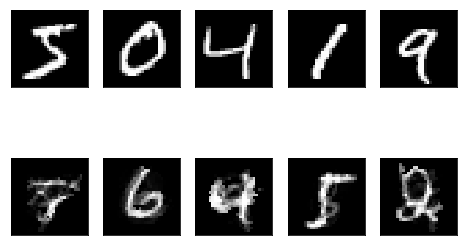

Epoch:  8 | train loss 0.0174 


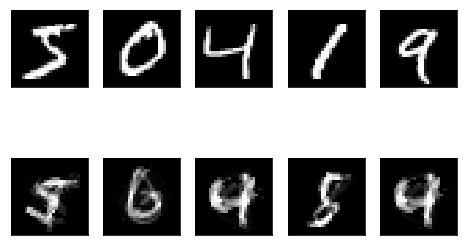

Epoch:  9 | train loss 0.0159 


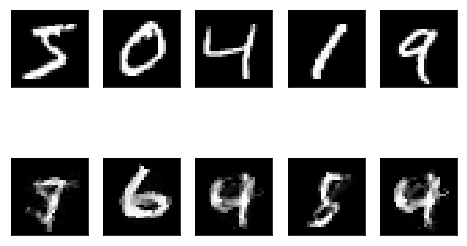

In [47]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

autoencoder = AutoEncoder().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(),lr=LR)
loss_func = nn.MSELoss()

for epoch in range(EPOCH):
    for step,(b_x,b_labels) in enumerate(train_loader):      # dim of b_x: 64*28*28,    
                                                    # 这里的b_labels是标签，其实用不上的，因为是自编码，最后其实是要跟自身(b_x)比较
        b_x = x.view(-1,28*28).to(device)                 
        b_y = x.view(-1,28*28).to(device)                 #这里的b_y其实也是b_x，因为是要跟自身比较
        
        encoded,decoded = autoencoder(b_x)
              
        loss = loss_func(decoded,b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step%1000 == 0:
            print("Epoch: ", epoch, "| train loss %.4f " % loss.cpu().data.numpy())
            
            # original data (first row) for viewing
            view_data = train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.
            view_data = view_data.to(device)
            # plot decoded image
            _, decoded_data = autoencoder(view_data)
            
            # initialize figure
            f, a = plt.subplots(2, N_TEST_IMG, figsize=(8, 5))
            plt.ion()   # continuously plot
            
            # watch the evolotion of decoding
            for i in range(N_TEST_IMG):
                a[0][i].imshow(np.reshape(view_data.cpu().data.numpy()[i], (28, 28)), cmap='gray')
                a[0][i].set_xticks(());a[0][i].set_yticks(())
                a[1][i].clear()
                a[1][i].imshow(np.reshape(decoded_data.cpu().data.numpy()[i], (28, 28)), cmap='gray')
                a[1][i].set_xticks(()); a[1][i].set_yticks(())
            plt.draw(); plt.pause(0.05)  
            plt.ioff()
            plt.show()        

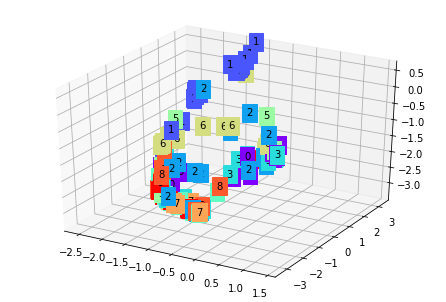

In [54]:
# visualize the 3D plot by using the encoded data
view_data = train_data.train_data[:200].view(-1, 28*28).type(torch.FloatTensor)/255.
# only the encoded data needed
encoded_data, _ = autoencoder(view_data.to(device))

fig = plt.figure(2); ax = Axes3D(fig)
X, Y, Z = encoded_data.cpu().data[:, 0].numpy(), encoded_data.cpu().data[:, 1].numpy(), encoded_data.cpu().data[:, 2].numpy()
values = train_data.train_labels[:200].numpy()
for x, y, z, s in zip(X, Y, Z, values):
    c = cm.rainbow(int(255*s/9));ax.text(x, y, z, s, backgroundcolor=c)
ax.set_xlim(X.min(), X.max()); ax.set_ylim(Y.min(), Y.max()); ax.set_zlim(Z.min(), Z.max())
plt.show()